In [1]:
dependencies = [
    "kagtool",
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/Users/cactus/.fastai/data/pascal_2007/test'),Path('/Users/cactus/.fastai/data/pascal_2007/segmentation'),Path('/Users/cactus/.fastai/data/pascal_2007/test.csv'),Path('/Users/cactus/.fastai/data/pascal_2007/test.json'),Path('/Users/cactus/.fastai/data/pascal_2007/valid.json'),Path('/Users/cactus/.fastai/data/pascal_2007/train.json'),Path('/Users/cactus/.fastai/data/pascal_2007/train'),Path('/Users/cactus/.fastai/data/pascal_2007/train.csv')]

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
# get first column
df.iloc[:,0] 

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
dblock = DataBlock()

In [7]:
dsets = dblock.datasets(df)
type(dsets)

fastai.data.core.Datasets

In [8]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [9]:
dsets.train

(#4009) [(fname       003214.jpg
labels             car
is_valid         False
Name: 1621, dtype: object, fname       003214.jpg
labels             car
is_valid         False
Name: 1621, dtype: object),(fname       007424.jpg
labels             car
is_valid          True
Name: 3741, dtype: object, fname       007424.jpg
labels             car
is_valid          True
Name: 3741, dtype: object),(fname        006159.jpg
labels      pottedplant
is_valid           True
Name: 3092, dtype: object, fname        006159.jpg
labels      pottedplant
is_valid           True
Name: 3092, dtype: object),(fname       009502.jpg
labels             dog
is_valid          True
Name: 4775, dtype: object, fname       009502.jpg
labels             dog
is_valid          True
Name: 4775, dtype: object),(fname           004356.jpg
labels      person bicycle
is_valid              True
Name: 2192, dtype: object, fname           004356.jpg
labels      person bicycle
is_valid              True
Name: 2192, dtype: obje

In [10]:
x, y = dsets.train[0]
x,y

(fname       003214.jpg
 labels             car
 is_valid         False
 Name: 1621, dtype: object,
 fname       003214.jpg
 labels             car
 is_valid         False
 Name: 1621, dtype: object)

In [11]:
# It just return the whole row, because the data block doesn't know how to infer x and y
# by default it's expecting a column input and target
# but we can provide a custom name
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)

# you could also use
# dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
# but lambdas don't serialize, so when u gonna export your model, you will encounter some issues!

# anyway!
dsets = dblock.datasets(df)
x,y = dsets.train[0]
x,y

('007910.jpg', 'person')

In [12]:
# better!

In [13]:
df.iloc[2]

fname         000009.jpg
labels      horse person
is_valid            True
Name: 2, dtype: object

In [14]:
# we need to split the labels into a list
# we also need a full path for images
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[6]

(Path('/Users/cactus/.fastai/data/pascal_2007/train/008068.jpg'), ['bird'])

In [15]:
# better!

In [16]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x347,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [17]:
# TensorMultiCategory corresponds to...
L(dsets.train.vocab)


(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

In [18]:
# so TensorMultiCategory numericalized the vocab
# we can find back the label with

# "same as argmax"
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['car']

<Axes: >

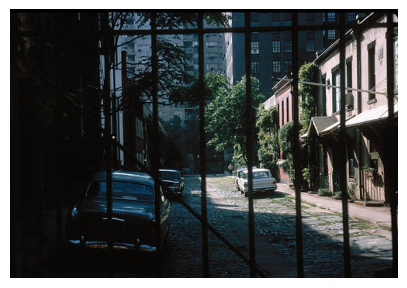

In [19]:
dsets.train[0][0].show()

In [20]:
# indeed it's a bird!

In [21]:
# we are missing the split in our datablock, so far it's just using a random split
# but the csv is telling us which one are part of the validation set
df.head()
     


,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [22]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

len(splitter(df)[0]), len(splitter(df)[1])

(2501, 2510)

In [23]:


dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [24]:
# note that first item is not a bird anymore cause we changed the split

In [25]:
# uncomment to see the what we missed
# dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
#                    splitter=splitter,
#                    get_x=get_x, 
#                    get_y=get_y)
# dls = dblock.dataloaders(df)
# dls.show_batch()

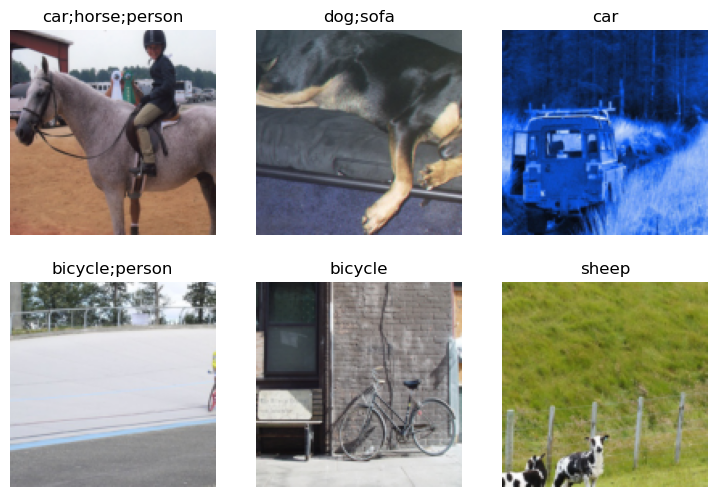

In [26]:
# the last step now is to collate very image into a tensor, to do that we need to resize them first
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)
dls.show_batch(max_n=6)

In [27]:
learn = vision_learner(dls, resnet18)
# learn.model

In [28]:
# let's look at what fastai created for us based on the dls (ImageBlock and MultiCategoryBlock)

# the to_cpu is really for debug only
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)

# let's look at the shape of our model activations (or at least the end of the forward pass)
activs.shape

torch.Size([64, 20])

In [29]:
activs[0]

TensorImage([ 3.5205, -2.4215, -0.9344,  4.0737, -2.9401,  2.3703, -1.2900,
             -0.5789,  0.1007,  0.8354, -1.1842,  0.2692,  2.5283,  3.7708,
              2.4764,  2.0947,  2.1488,  0.0218, -1.1549, -1.4555],
            grad_fn=<AliasBackward0>)

In [30]:
# try to guess why does the activation have this shape, and what are the logits

In [31]:
# 64 means we showed 64 training examples X
dls.bs

64

In [32]:
# and 20 is because we want to end up with any of these 20 targets
len(dls.vocab)

20

In [33]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.994437,0.722509,0.201434,00:29
1,0.869070,0.576491,0.235259,00:26
2,0.639199,0.212087,0.819502,00:25
3,0.390090,0.145265,0.928984,00:24


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.157374,0.130272,0.935996,00:28
1,0.138382,0.120494,0.944920,00:27
2,0.121324,0.118259,0.943924,00:27


# Tuning Metric

In [34]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11825934797525406,0.9193824529647827]

In [35]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.11825934797525406,0.935358464717865]

In [36]:
preds,targs = learn.get_preds()

In [37]:
preds.shape

torch.Size([2510, 20])

In [38]:
for i in range(10):
    print(accuracy_multi(preds, targs, thresh=i*0.1, sigmoid=False))

TensorBase(0.0776)
TensorBase(0.9194)
TensorBase(0.9439)
TensorBase(0.9521)
TensorBase(0.9565)
TensorBase(0.9577)
TensorBase(0.9568)
TensorBase(0.9558)
TensorBase(0.9531)
TensorBase(0.9487)


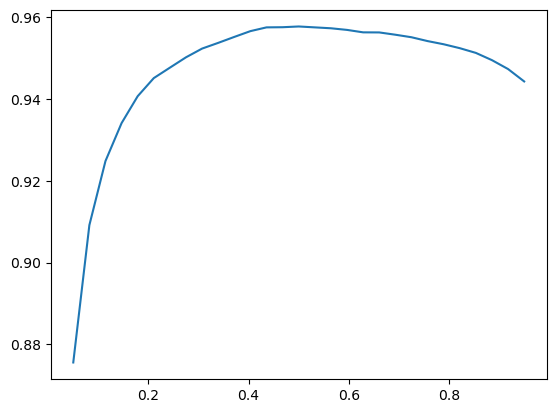

In [39]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [40]:
learn.metrics = partial(accuracy_multi, thresh=0.5)

In [41]:
import ipywidgets as widgets

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [42]:
from fastai.vision.all import *

import platform

def get_latest_upload(btn_upload):
    if 'darwin' in platform.system().lower():
        if btn_upload.data: return btn_upload.data[-1] 
    else:
        if btn_upload.value: return btn_upload.value[-1].content.tobytes()
    print("NO FILES UPLOADED!")

def show_uploaded_img(btn_upload):
    data = get_latest_upload(btn_upload)
    if data:
        PILImage.create(data).show()

show_uploaded_img(btn_upload)
preds = learn.predict(img)
preds

AttributeError: 'FileUpload' object has no attribute 'data'

it is a ['person']


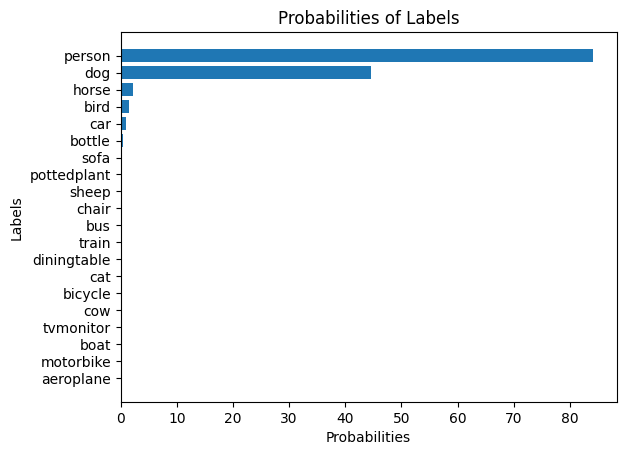

In [ ]:
catname = preds[0] if preds[0] else 'unknown'
print(f'it is a {catname}')


def show_probs():
    probabilities = preds[2]
    probabilities = [p * 100 for p in probabilities]
    results = {label: prob for label, prob in zip(learn.dls.vocab, probabilities)}
    sorted_results = sorted(results.items(), key=lambda x: x[1])
    
    import matplotlib.pyplot as plt
    
    # Assuming you have the probabilities stored in a list called 'probabilities'
    labels = [label for label, _ in sorted_results]
    probs = [prob for _, prob in sorted_results]
    
    plt.barh(labels, probs)
    plt.xlabel('Probabilities')
    plt.ylabel('Labels')
    plt.title('Probabilities of Labels')
    plt.show()


if preds[0]:
    show_probs()